<a href="https://colab.research.google.com/github/Urz1/Deep_Learning/blob/main/Character_Level_Language_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Character-Level Language Model

This notebook demonstrates the training of a simple character-level language model using PyTorch. The model will learn to predict the next character in a sequence based on the preceding characters. We will train this model on a dataset of names.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

## Data Loading and Preprocessing

First, we load the dataset of names and create mappings between characters and integers. The `stoi` dictionary maps characters to integers, and `itos` maps integers back to characters. The special character '.' is used to represent the start and end of a name.

In [2]:
words = open('names.txt', 'r').read().splitlines()

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = { s: i + 1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


We then build the dataset by creating input-output pairs. The input consists of a sequence of `block_size` characters (the context), and the output is the next character in the sequence. We use a block size of 3, meaning we consider the previous 3 characters to predict the next one. The dataset is split into training, development, and test sets.

In [6]:
# build the dataset
def build_dataset(words):
  block_size = 3
  X, Y = [], []

  for w in words:
    context  = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


## Model Architecture

The model consists of an embedding layer, a hidden layer with a tanh activation function, and an output layer.

- **Embedding Layer (C):** This layer maps each character (represented as an integer) into a low-dimensional dense vector. The size of the embedding is 2 in this case.
- **Hidden Layer:** This is a linear layer that takes the concatenated embeddings of the input characters and transforms them into a hidden representation. We use a hidden layer size of 300. A tanh activation function is applied to the output of the hidden layer to introduce non-linearity.
- **Output Layer:** This is another linear layer that takes the output of the hidden layer and produces logits for each possible next character. The size of the output layer is equal to the number of unique characters (27, including '.').

In [7]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
w1 = torch.randn((6, 300), generator  = g)
b1 = torch.randn(300, generator = g)
w2 = torch.randn((300, 27), generator = g)
b2 = torch.randn(27, generator = g)

parameters = [C, w1, b1, w2, b2]

We can see the total number of parameters in our model:

In [8]:
sum(p.nelement() for p in parameters)

10281

We set the `requires_grad` attribute to `True` for all parameters so that gradients can be computed during the backward pass.

In [9]:
for p in parameters:
  p.requires_grad = True

We will explore different learning rates to find an optimal value for training.

In [10]:
lre = torch.linspace(-3, 0, 100)
lrs = 10**lre

## Training Loop

We train the model using mini-batch gradient descent. In each iteration, we:

1. **Construct a mini-batch:** Select a random subset of the training data.
2. **Forward pass:** Compute the output logits for the mini-batch.
3. **Calculate the loss:** Compute the cross-entropy loss between the logits and the target characters.
4. **Backward pass:** Compute the gradients of the loss with respect to the parameters.
5. **Update parameters:** Adjust the parameters in the direction that minimizes the loss, using a learning rate.
6. **Track stats:** Record the learning rate and the loss for analysis.

In [ ]:
lri = []
lossi = []
step = []
for i in range(100):

  #  mini batch construct
  ix = torch.randint(0, Xtr.shape[0], (len(Ydev), ))

  # forward pass
  emb = C[Xtr[ix]] # (-1, 3, 2)
  h = torch.tanh(emb.view(-1,6) @ w1 + b1)
  logits = h @ w2 + b2 # ( -1, 27)
  loss = F.cross_entropy(logits, Ytr[ix])

  #  backward Pass
  for p in parameters:
    p.grad=  None
  loss.backward()

  # update
  lr = lrs[i]
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  step.append(i)
  lossi.append(loss.item())
  lri.append(lrs[i])

## Evaluation

After training, we evaluate the model's performance by calculating the loss on the training and development datasets.

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2 # (-1 , 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(22.1007, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 6) @ w1 + b1)
logits = h @ w2 + b2 # (-1 , 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(22.0615, grad_fn=<NllLossBackward0>)

## Visualization

We can visualize the training process by plotting the loss over the training steps. This helps us see how well the model is learning.

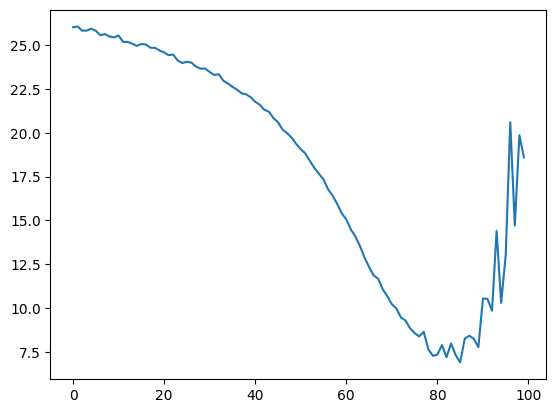

In [ ]:
plt.plot(step, lossi)

We can also visualize the character embeddings learned by the model. Characters that are semantically similar (e.g., vowels or consonants) might be located closer to each other in the embedding space.

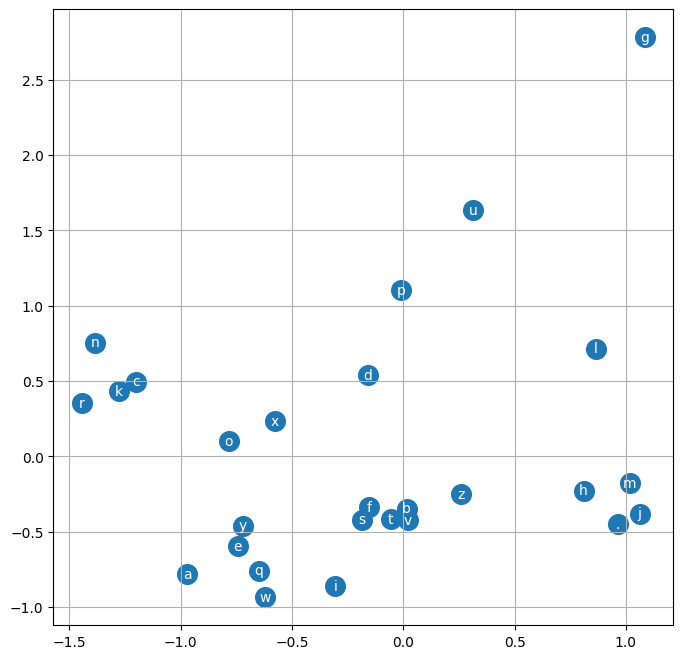

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(C[:, 0].data, C[:,1].data, s = 200)
for i in range(C.shape[0]):
  plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid('minor')

## Conclusion

This notebook demonstrated the process of building and training a simple character-level language model. We loaded and preprocessed the data, defined the model architecture, set up the training loop, and evaluated the model's performance.